In [28]:
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

class MeanImageDataset(Dataset):
    def __init__(self, mnist_data, cifar10_data, transform=None):
        self.mnist_data = mnist_data
        self.cifar10_data = cifar10_data
        self.transform = transform

    def __len__(self):
        return min(len(self.mnist_data), len(self.cifar10_data))

    def __getitem__(self, idx):
        mnist_image, _ = self.mnist_data[idx]
        cifar10_image, _ = self.cifar10_data[idx]

        mnist_image_resized = transforms.Resize((32, 32))(mnist_image)
        mnist_image_3ch = mnist_image_resized.repeat(3, 1, 1)

        mean_image = (mnist_image_3ch + cifar10_image) / 2

        if self.transform:
            mean_image = self.transform(mean_image)

        return mean_image, mnist_image_3ch, cifar10_image

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

mean_image_dataset = MeanImageDataset(mnist_dataset, cifar10_dataset)
train_loader = DataLoader(mean_image_dataset, batch_size=64, shuffle=True)


Files already downloaded and verified


In [29]:
import torch.nn as nn

class DualDecoderAutoencoder(nn.Module):
    def __init__(self):
        super(DualDecoderAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU()
        )

        self.decoder_cifar10 = nn.Sequential(
            nn.Linear(256, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self.decoder_mnist = nn.Sequential(
            nn.Linear(256, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed_cifar10 = self.decoder_cifar10(latent)
        reconstructed_mnist = self.decoder_mnist(latent)
        return reconstructed_cifar10, reconstructed_mnist


In [ ]:
from tqdm import tqdm

model = DualDecoderAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    for mean_image, mnist_image, cifar10_image in train_loader:
        optimizer.zero_grad()
        outputs_cifar10, outputs_mnist = model(mean_image)
        loss_cifar10 = criterion(outputs_cifar10, cifar10_image)
        loss_mnist = criterion(outputs_mnist, mnist_image)
        loss = loss_cifar10 + loss_mnist
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [31]:
model = DualDecoderAutoencoder()
model.load_state_dict(torch.load('/content/dual_decoder_autoencoder.pth', map_location='cpu'))

<All keys matched successfully>

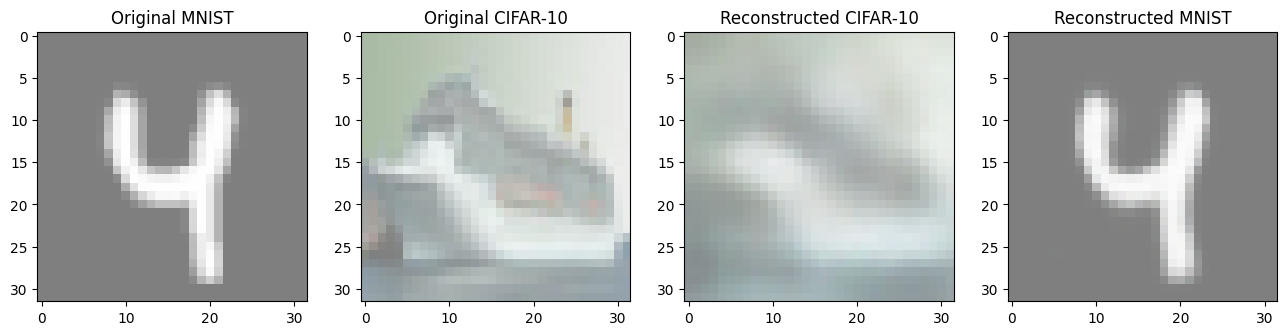

In [39]:
with torch.no_grad():
    for mean_image, mnist_image, cifar10_image in train_loader:
        reconstructed_cifar10, reconstructed_mnist = model(mean_image)
        break

if len(reconstructed_mnist.shape) == 4:
    reconstructed_mnist = reconstructed_mnist.squeeze(0)

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title("Original MNIST")
plt.imshow(mnist_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)

plt.subplot(1, 4, 2)
plt.title("Original CIFAR-10")
plt.imshow(cifar10_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)

plt.subplot(1, 4, 3)
plt.title("Reconstructed CIFAR-10")
plt.imshow(reconstructed_cifar10[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)

plt.subplot(1, 4, 4)
plt.title("Reconstructed MNIST")
plt.imshow(reconstructed_mnist[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)

plt.show()


In [36]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

model.eval()

def calculate_metrics(original, reconstructed):
    ssim_value = ssim(original, reconstructed, multichannel=True)
    psnr_value = psnr(original, reconstructed)
    return ssim_value, psnr_value

with torch.no_grad():
    for mean_image, mnist_image, cifar10_image in train_loader:
        reconstructed_cifar10, reconstructed_mnist = model(mean_image)
        break

if len(reconstructed_mnist.shape) == 4:
    reconstructed_mnist = reconstructed_mnist.squeeze(0)

mnist_image = mnist_image[0].permute(1, 2, 0).numpy()
cifar10_image = cifar10_image[0].permute(1, 2, 0).numpy()
reconstructed_cifar10 = reconstructed_cifar10[0].permute(1, 2, 0).numpy()
reconstructed_mnist = reconstructed_mnist[0].permute(1, 2, 0).numpy()

print("Shapes for comparison:")
print(f"Original MNIST shape: {mnist_image.shape}")
print(f"Reconstructed MNIST shape: {reconstructed_mnist.shape}")
print(f"Original CIFAR-10 shape: {cifar10_image.shape}")
print(f"Reconstructed CIFAR-10 shape: {reconstructed_cifar10.shape}")

ssim_cifar10, psnr_cifar10 = calculate_metrics(cifar10_image, reconstructed_cifar10)
ssim_mnist, psnr_mnist = calculate_metrics(mnist_image, reconstructed_mnist)

print(f'SSIM (CIFAR-10): {ssim_cifar10:.4f}, PSNR (CIFAR-10): {psnr_cifar10:.4f}')
print(f'SSIM (MNIST): {ssim_mnist:.4f}, PSNR (MNIST): {psnr_mnist:.4f}')


Shapes for comparison:
Original MNIST shape: (32, 32, 3)
Reconstructed MNIST shape: (32, 32, 3)
Original CIFAR-10 shape: (32, 32, 3)
Reconstructed CIFAR-10 shape: (32, 32, 3)
SSIM (CIFAR-10): 0.6727, PSNR (CIFAR-10): 18.7639
SSIM (MNIST): 0.9691, PSNR (MNIST): 27.9407


<ipython-input-36-c9bb2f8b763b>:8: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(original, reconstructed, multichannel=True)


In [40]:
pip install torchviz


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

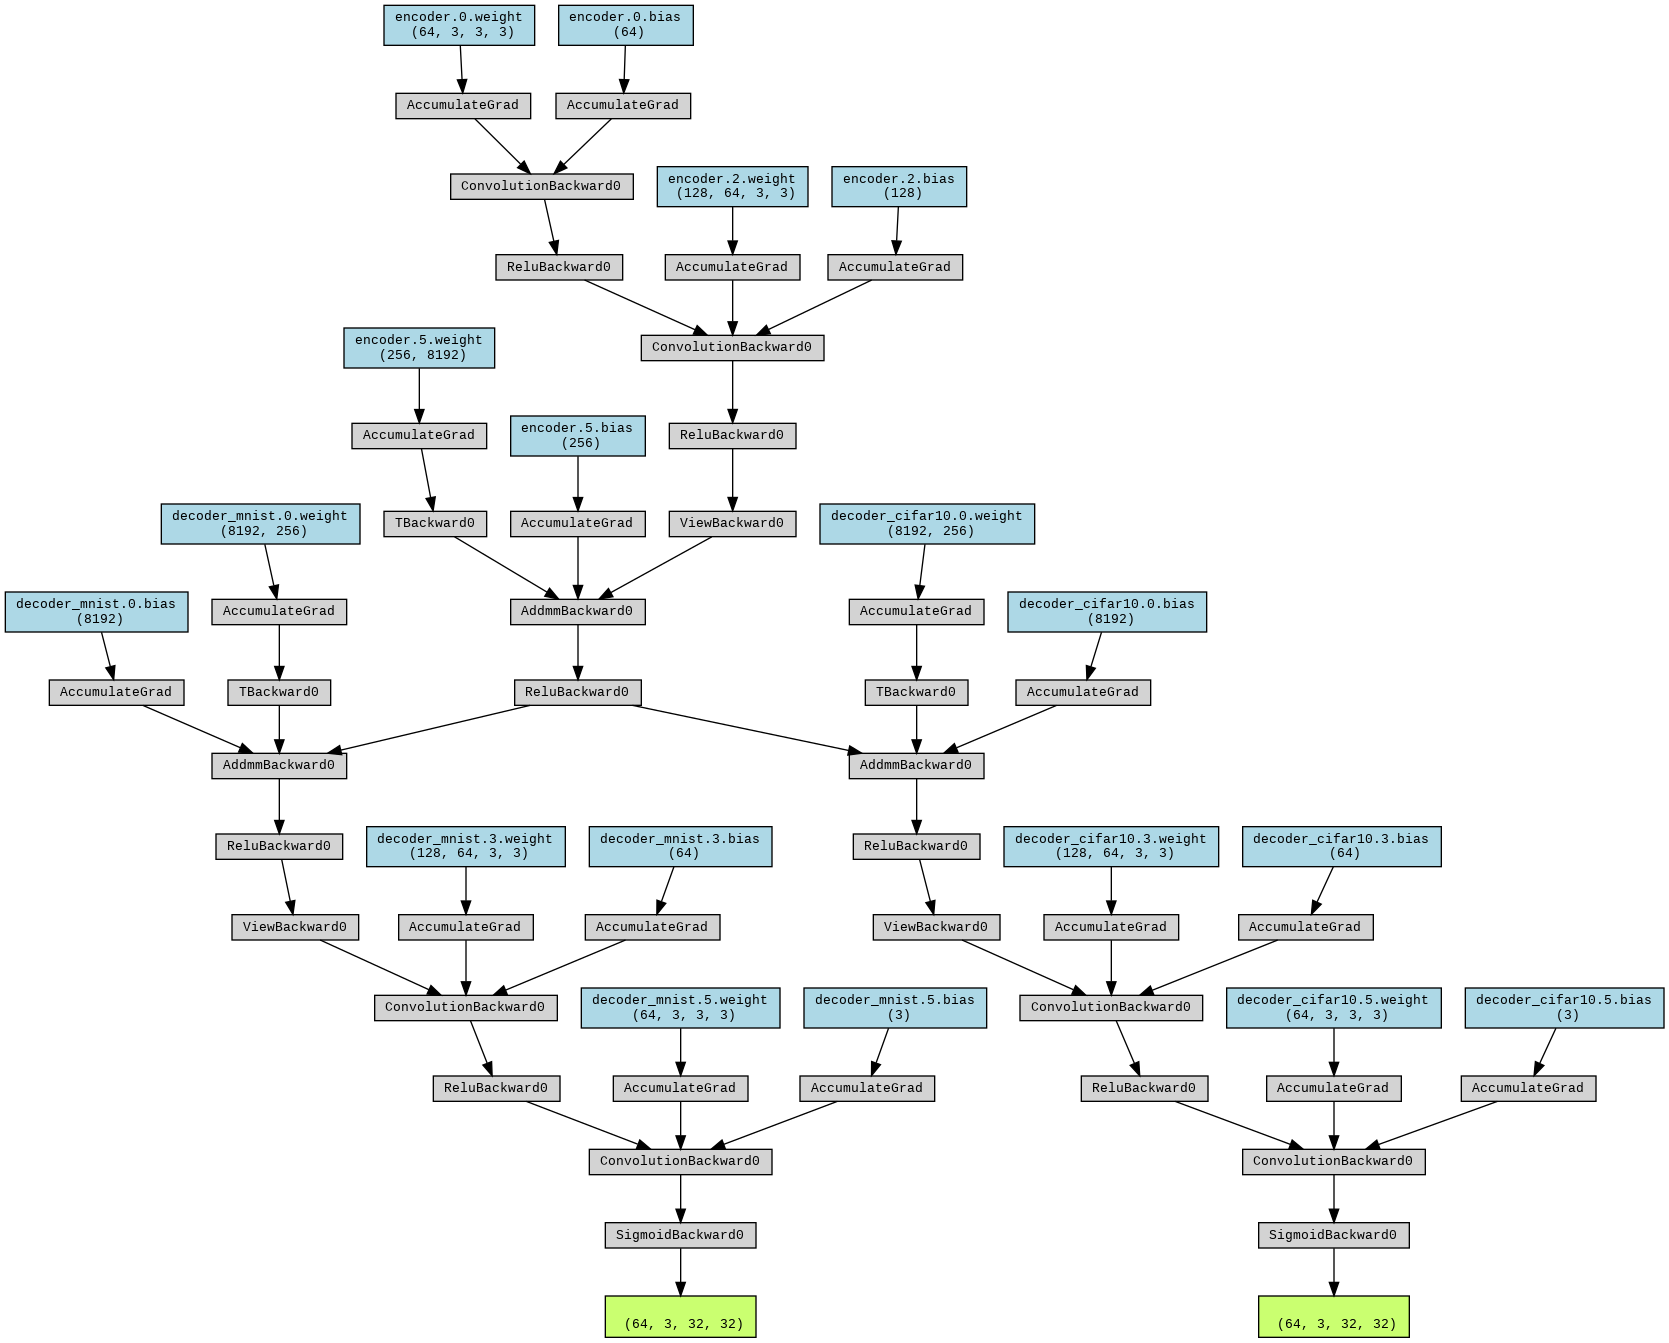

In [43]:
from torchviz import make_dot

model = DualDecoderAutoencoder()

data_iter = iter(train_loader)
mean_image, mnist_image, cifar10_image = next(data_iter)

outputs_cifar10, outputs_mnist = model(mean_image)

dot = make_dot((outputs_cifar10, outputs_mnist), params=dict(model.named_parameters()))

dot.format = 'png'
dot.render('dual_decoder_autoencoder')

from IPython.display import Image
Image(filename='dual_decoder_autoencoder.png')
